# Modelo de Regresión Simple

In [1]:
#from pyspark import SparkContext
#sc = SparkContext()
#from pyspark.sql import SQLContext
#sqlContext=SQLContext(sc)

In [2]:
bd5 = sqlContext.read.format(
    "com.databricks.spark.csv"
).option("header", "true").load("file:/home/cloudera/Documents/Ficheros de trabajo/bd5.csv", inferSchema=True)
sqlContext.registerDataFrameAsTable(bd5, "bd5")

## Descripción Previa de la Base de Datos

Resumen Numérico

In [3]:
pdf4 = bd5.sample(False, 0.1, 0).select('Dest','Horario','ArrDelay','DepDelay','RetrasoNeto').toPandas()
pdf4.corr()

,Horario,ArrDelay,DepDelay,RetrasoNeto
Horario,1.000000,0.110390,0.106962,0.042998
ArrDelay,0.110390,1.000000,0.959840,0.418959
DepDelay,0.106962,0.959840,1.000000,0.147394
RetrasoNeto,0.042998,0.418959,0.147394,1.000000


Resumen Gráfico

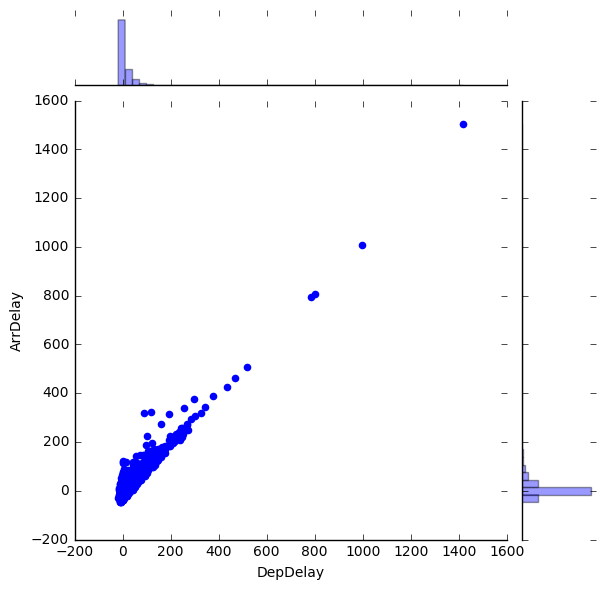

In [4]:
import seaborn as sns
%matplotlib inline
sns.jointplot(x="DepDelay", y="ArrDelay", data=pdf4)

## Configuración de la base de datos

In [5]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

assembler = VectorAssembler(
    inputCols=['DepDelay'],
    outputCol='features')

bd6 = assembler.transform(bd5).select(col("ArrDelay").alias("label"),'features')
bd6.show()

+-----+--------+
|label|features|
+-----+--------+
|-16.0|   [0.0]|
| -9.0|   [0.0]|
|-18.0|  [-2.0]|
|119.0| [130.0]|
|-18.0|  [-8.0]|
| -5.0|   [2.0]|
|  0.0|  [11.0]|
| -7.0|  [-2.0]|
|-21.0|  [-3.0]|
|-13.0|  [-3.0]|
|-15.0|   [2.0]|
| -9.0|  [-4.0]|
|-14.0|   [1.0]|
|-14.0|   [6.0]|
| -7.0|  [-4.0]|
|  6.0|  [18.0]|
|-15.0|   [0.0]|
| -8.0|   [0.0]|
| -4.0|   [7.0]|
| -4.0|  [-3.0]|
+-----+--------+
only showing top 20 rows



### Ajuste del modelo

In [6]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression()
model = lr.fit(bd6)
pred = model.transform(bd6)

/usr/lib/spark/python/pyspark/ml/regression.py:123: UserWarning: weights is deprecated. Use coefficients instead.
  warnings.warn("weights is deprecated. Use coefficients instead.")


Coeficientes

In [7]:
print(model.intercept,model.coefficients)

-4.3994410804913295 [1.02786002478]


Modelo Teórico:

__ArrDelay = $\beta_0$ + $\beta_1$*DepDelay + $\epsilon$__ 


Modelo Predictivo:

__ArrDelay = -4.4 + 1.03*DepDelay__




Valores Predichos y Residuos

In [8]:
pred = pred.withColumn('residual', pred.label-pred.prediction)
pred.show()

+-----+--------+-------------------+--------------------+
|label|features|         prediction|            residual|
+-----+--------+-------------------+--------------------+
|-16.0|   [0.0]|-4.3994410804913295| -11.600558919508671|
| -9.0|   [0.0]|-4.3994410804913295| -4.6005589195086705|
|-18.0|  [-2.0]| -6.455161130042824| -11.544838869957175|
|119.0| [130.0]|  129.2223621403558| -10.222362140355813|
|-18.0|  [-8.0]|-12.622321278697306| -5.3776787213026935|
| -5.0|   [2.0]| -2.343721030939835|  -2.656278969060165|
|  0.0|  [11.0]|  6.907019192041889|  -6.907019192041889|
| -7.0|  [-2.0]| -6.455161130042824|  -0.544838869957176|
|-21.0|  [-3.0]| -7.483021154818571| -13.516978845181429|
|-13.0|  [-3.0]| -7.483021154818571|  -5.516978845181429|
|-15.0|   [2.0]| -2.343721030939835| -12.656278969060164|
| -9.0|  [-4.0]| -8.510881179594318|-0.48911882040568244|
|-14.0|   [1.0]|-3.3715810557155823| -10.628418944284418|
|-14.0|   [6.0]| 1.7677190681631538| -15.767719068163153|
| -7.0|  [-4.0

Representación gráfica de resultados

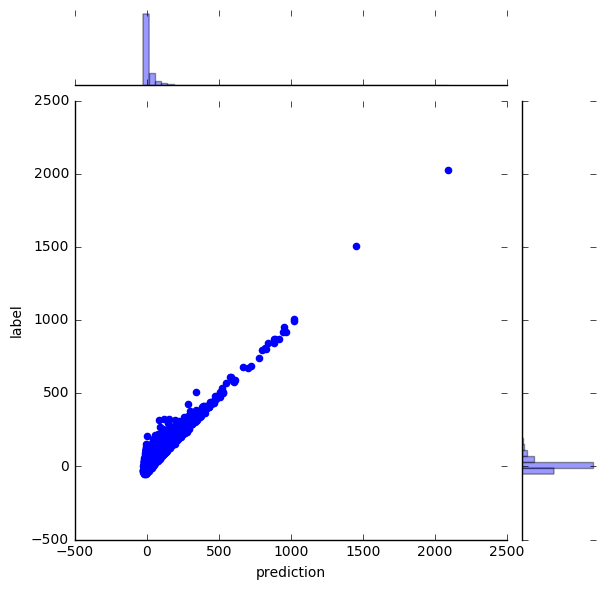

In [9]:
pdpred = pred.toPandas()
sns.jointplot(x="prediction", y="label", data=pdpred)

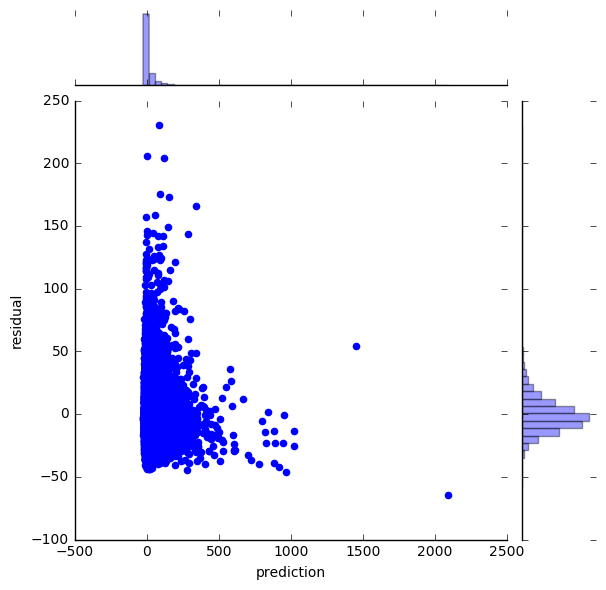

In [10]:
sns.jointplot(x="prediction", y="residual", data=pdpred)

Métricas de Evaluación (R2, RMSE, MAE)

In [11]:
from pyspark.ml.evaluation import RegressionEvaluator

print(RegressionEvaluator(metricName="rmse").evaluate(pred))
print(RegressionEvaluator(metricName="r2").evaluate(pred))


15.498421344920363
0.9161065747950499


Otros parámetros opcionales del modelo

In [12]:
#lr = LinearRegression()
#lr = LinearRegression(
    #maxIter=5, 
    #regParam=0.0,
    #elasticNetParam=0.0,
    #solver="normal", 
    #weightCol="weight")